In [51]:
# imports
%matplotlib notebook
import matplotlib.pyplot as plt
from camera import take_picture
import numpy as np
import os
import random

In [52]:
# download dlib models
from dlib_models import download_model, download_predictor, load_dlib_models
download_model()
download_predictor()
from dlib_models import models

File already exists:
	c:\users\aleks_000\desktop\bwsi\cogworks_2018\dependencies\dlibmodels\dlib_models\dlib_face_recognition_resnet_model_v1.dat
File already exists:
	c:\users\aleks_000\desktop\bwsi\cogworks_2018\dependencies\dlibmodels\dlib_models\shape_predictor_68_face_landmarks.dat


In [53]:
load_dlib_models()
face_detect = models["face detect"]
shape_predictor = models["shape predict"]

In [71]:
def readfile_emotion(filename):
    with open(filename, mode='r') as file:
        return int(float(file.read().split()[0]))

def readfile_landmarks(filename):
    with open(filename, mode='r') as file:
        return np.array([float(x) for x in file.read().split()]).reshape(-1, 2)

In [79]:
import matplotlib.image as mpimg

def import_cohn_kanade_full(dataset="database\Cohn-Kanade", extension=".txt", extension_images=".png", cutoff=0.125):
    images = []
    landmarks = []
    emotions = []
    
    path_images = os.path.join(dataset, "cohn-kanade-images")
    path_landmarks = os.path.join(dataset, "Landmarks")
    path_emotions = os.path.join(dataset, "Emotion")
    # for every subject
    subjects = os.listdir(path_images)
    random.shuffle(subjects)
    for di in subjects:
        dire_images = os.path.join(path_images, di)
        dire_landmarks = os.path.join(path_landmarks, di)
        dire_emotions = os.path.join(path_emotions, di)
        if os.path.isdir(dire_images) and os.path.isdir(dire_landmarks) and os.path.isdir(dire_emotions):
            # for every sequence
            for subdi in os.listdir(dire_images):
                subdire_images = os.path.join(dire_images, subdi)
                subdire_landmarks = os.path.join(dire_landmarks, subdi)
                subdire_emotions = os.path.join(dire_emotions, subdi)
                if os.path.isdir(subdire_images) and os.path.isdir(subdire_landmarks) and os.path.isdir(subdire_emotions):
                    # find the first and only emotion file
                    emotion = None
                    for fi in os.listdir(subdire_emotions):
                        if fi.endswith(extension) and not fi.startswith("._"):
                            path = os.path.join(subdire_emotions, fi)
                            emotion = readfile_emotion(path)
                            break
                    # for every neutral landmark+image
                    valid_images = [fi for fi in os.listdir(subdire_images) if fi.endswith(extension_images) and not fi.startswith("._")]
                    valid_landmarks = [fi for fi in os.listdir(subdire_landmarks) if fi.endswith(extension) and not fi.startswith("._")]
                    split = int(len(valid_images)*cutoff)
                    for fi_image, fi_landmark in zip(valid_images[:split], valid_landmarks[:split]):
                        path_image = os.path.join(subdire_images, fi_image)
                        path_landmark = os.path.join(subdire_landmarks, fi_landmark)
                        image = mpimg.imread(path_image)
                        landmark = readfile_landmarks(path_landmark)
                        # add to return array
                        images.append(image)
                        emotions.append(0)
                        landmarks.append(landmark)
                    if emotion is None:
                        continue
                    # for every emotional landmark+image
                    for fi_image, fi_landmark in zip(valid_images[split:], valid_landmarks[split:]):
                        path_image = os.path.join(subdire_images, fi_image)
                        path_landmark = os.path.join(subdire_landmarks, fi_landmark)
                        image = mpimg.imread(path_image)
                        landmark = readfile_landmarks(path_landmark)
                        # add to return array
                        images.append(image)
                        emotions.append(emotion)
                        landmarks.append(landmark)
    return images, np.array(landmarks), np.array(emotions)

In [80]:
batch_imgs, batch_faces, y = import_cohn_kanade_full()

In [139]:
# based on Dlib: https://github.com/davisking/dlib/blob/master/dlib/image_transforms/interpolation.h

def get_face_chip_details(dets, size=200, padding=0.2):
    assert dets.shape[1] == 68
    assert padding >= 0 and size > 0
    
    # Average positions of face points 17-67
    mean_face_shape_x = [
        0.000213256, 0.0752622, 0.18113, 0.29077, 0.393397, 0.586856, 0.689483, 0.799124,
        0.904991, 0.98004, 0.490127, 0.490127, 0.490127, 0.490127, 0.36688, 0.426036,
        0.490127, 0.554217, 0.613373, 0.121737, 0.187122, 0.265825, 0.334606, 0.260918,
        0.182743, 0.645647, 0.714428, 0.793132, 0.858516, 0.79751, 0.719335, 0.254149,
        0.340985, 0.428858, 0.490127, 0.551395, 0.639268, 0.726104, 0.642159, 0.556721,
        0.490127, 0.423532, 0.338094, 0.290379, 0.428096, 0.490127, 0.552157, 0.689874,
        0.553364, 0.490127, 0.42689
    ]
    mean_face_shape_y = [
        0.106454, 0.038915, 0.0187482, 0.0344891, 0.0773906, 0.0773906, 0.0344891,
        0.0187482, 0.038915, 0.106454, 0.203352, 0.307009, 0.409805, 0.515625, 0.587326,
        0.609345, 0.628106, 0.609345, 0.587326, 0.216423, 0.178758, 0.179852, 0.231733,
        0.245099, 0.244077, 0.231733, 0.179852, 0.178758, 0.216423, 0.244077, 0.245099,
        0.780233, 0.745405, 0.727388, 0.742578, 0.727388, 0.745405, 0.780233, 0.864805,
        0.902192, 0.909281, 0.902192, 0.864805, 0.784792, 0.778746, 0.785343, 0.778746,
        0.784792, 0.824182, 0.831803, 0.824182
    ]
    mean_face_shape = np.stack((mean_face_shape_x, mean_face_shape_y), axis=1)

    assert mean_face_shape.shape[0] == 68-17

    
#    if (55 <= i and i <= 59) or (65 <= i and i <= 67)
#        continue
#    
#    if 17 <= i and i <= 26
#        continue

    from_points = size*(padding+mean_face_shape)/(2*padding+1)
    to_points = dets
    
    # Ignore the chin (0-16)
    # Ignore the lower lip (55-59 and 65-67)
    # Ignore the eyebrows (17-26)
    to_points = np.concatenate((to_points[:, 27:55, :], to_points[:, 60:65, :]), axis=1)
    from_points = np.broadcast_to(np.concatenate((from_points[10:38, :], from_points[43:48, :]), axis=0), to_points.shape)
    
    return from_points, to_points

In [140]:
from_points, to_points = get_face_chip_details(batch_faces)

<IPython.core.display.Javascript object>


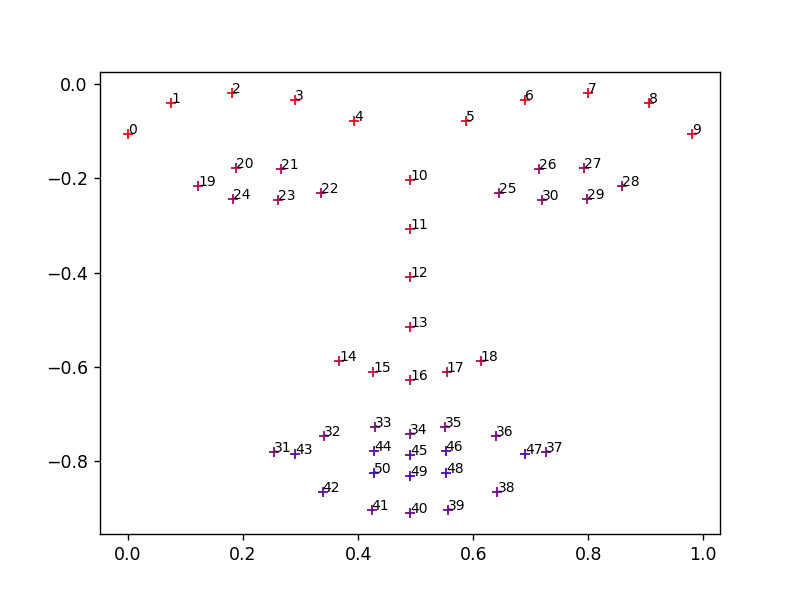

In [141]:
# See the average face
fig,ax = plt.subplots()

for i in range(68-17):
    ax.plot(mean_face_shape[i][0],-mean_face_shape[i][1],'+',color=(1-i/68, 0, i/68))
    ax.text(mean_face_shape[i][0],-mean_face_shape[i][1],str(i),color="black",fontsize=8)

<IPython.core.display.Javascript object>


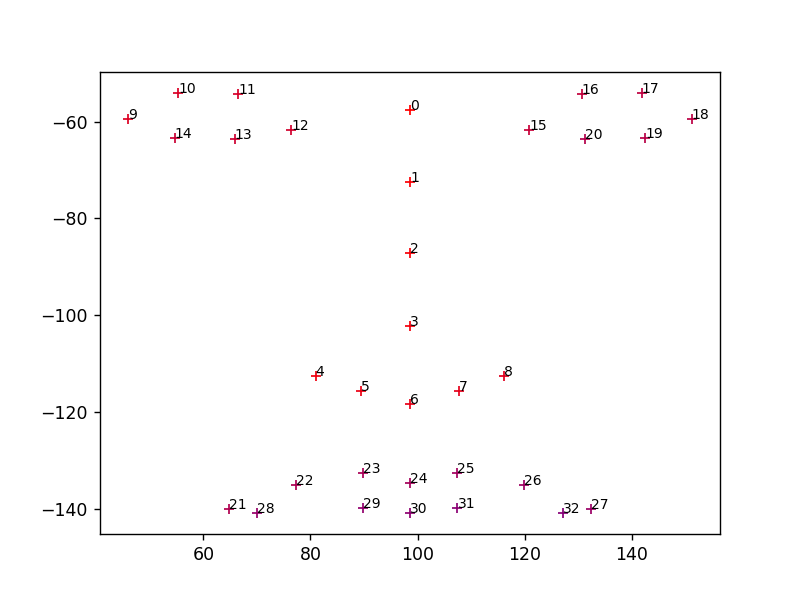

In [144]:
# See the returned faces
fig,ax = plt.subplots()

for i in range(33):
    ax.plot(from_points[0][i][0],-from_points[0][i][1],'+',color=(1-i/68, 0, i/68))
    ax.text(from_points[0][i][0],-from_points[0][i][1],str(i),color="black",fontsize=8)

<IPython.core.display.Javascript object>


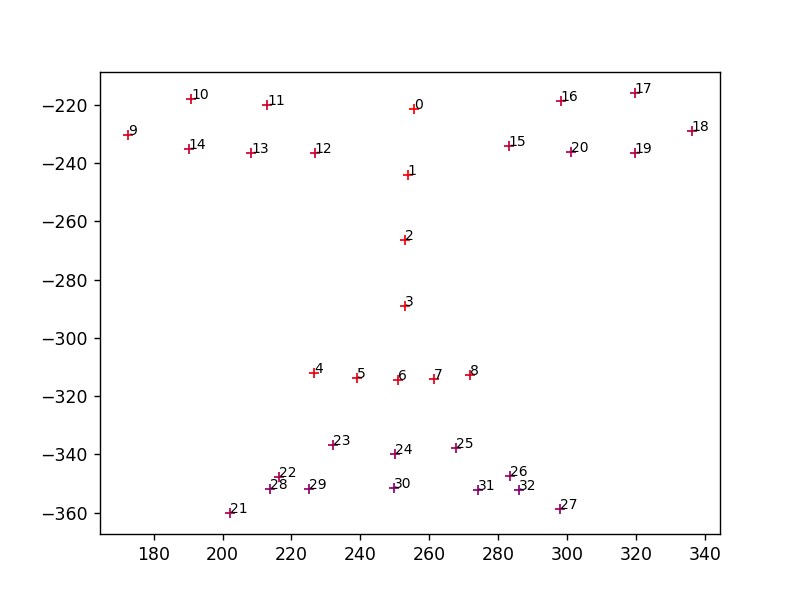

In [151]:
fig, ax = plt.subplots()

for index in range(to_points.shape[0]//20):
    ax.clear()
    for i in range(33):
        ax.plot(to_points[index][i][0],-to_points[index][i][1],'+',color=(1-i/68, 0, i/68))
        ax.text(to_points[index][i][0],-to_points[index][i][1],str(i),color="black",fontsize=8)
    fig.canvas.draw()

In [1107]:
# normalize
x = x.reshape((-1, 68, 2))

mean = np.mean(x, axis=1, keepdims=True)
std = np.std(x, axis=1, keepdims=True)

x = ((x - mean) / std).reshape(-1, 68*2)

In [1108]:
import sklearn

N = x.shape[0]
split = round(N*0.9)

xtrain = x[:split]
ytrain = y[:split]
xtest = x[split:]
ytest = y[split:]

# shuffle after to get new people in test
xtrain, ytrain = sklearn.utils.shuffle(xtrain, ytrain)
xtest, ytest = sklearn.utils.shuffle(xtest, ytest)

<IPython.core.display.Javascript object>


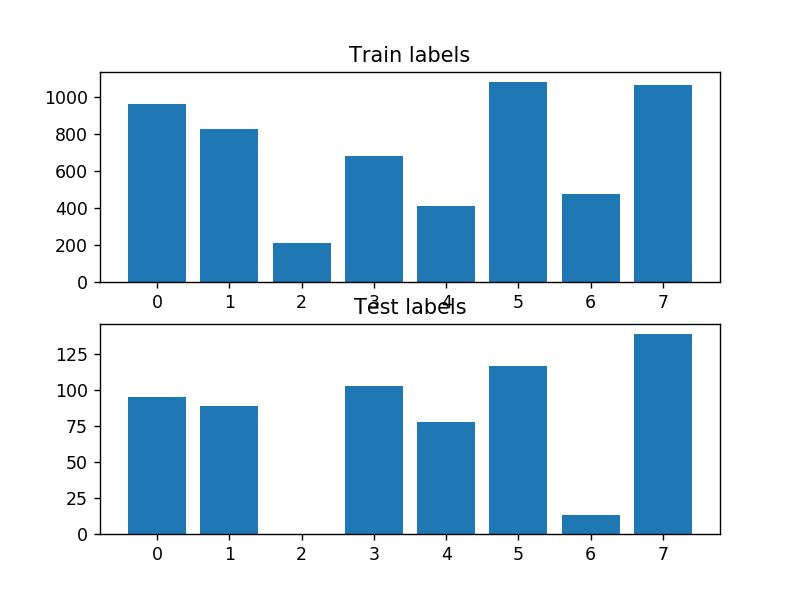

In [1109]:
from collections import Counter

fig, ax = plt.subplots(2)

hist_train = [0]*8
hist_test = [0]*8
for i, c in Counter(ytrain).items():
    hist_train[i] = c
for i, c in Counter(ytest).items():
    hist_test[i] = c
ax[0].bar(range(8), hist_train)
ax[1].bar(range(8), hist_test)
ax[0].set_title("Train labels");
ax[1].set_title("Test labels");

<IPython.core.display.Javascript object>


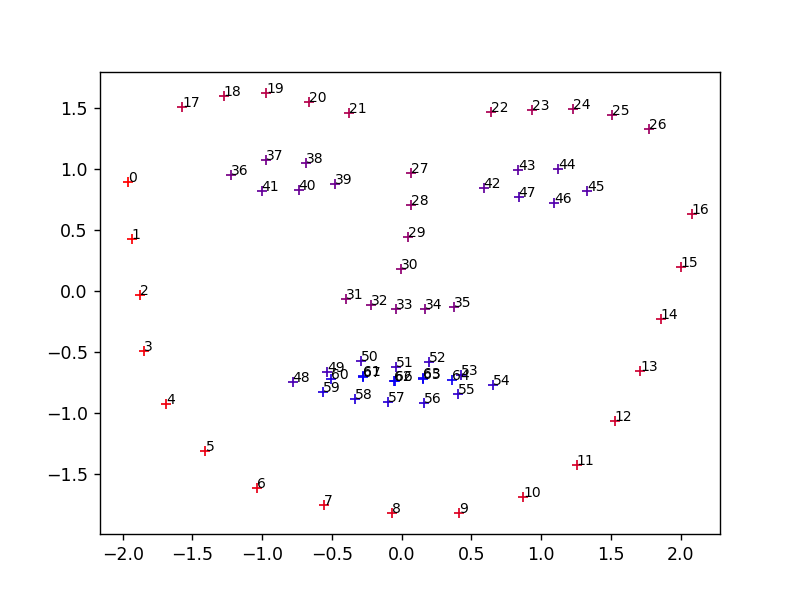

In [1237]:
fig, ax = plt.subplots()

# you can disable sklearn shuffling to see animations
for index in range(xtrain.shape[0]//100):
    ax.clear()
    for i in range(68):
        ax.plot(xtrain[index][2*i],-xtrain[index][2*i+1],'+',color=(1-i/68, 0, i/68))
        ax.text(xtrain[index][2*i],-xtrain[index][2*i+1],str(i),color="black",fontsize=8)
    fig.canvas.draw()

In [1176]:
from mynn.layers.dense import dense
from mynn.initializers.glorot_normal import glorot_normal
from mynn.activations.relu import relu

class Model:
    def __init__(self):
        self.dense1 = dense(2*68, 1000, weight_initializer=glorot_normal)
        self.dense2 = dense(1000, 333, weight_initializer=glorot_normal)
        self.dense3 = dense(333, 100, weight_initializer=glorot_normal)
        self.dense4 = dense(100, 33, weight_initializer=glorot_normal)
        self.dense5 = dense(33, 8, weight_initializer=glorot_normal)
    
    def __call__(self, x):
        return self.dense5(relu(self.dense4(relu(self.dense3(relu(self.dense2(relu(self.dense1(x)))))))))
    
    @property
    def parameters(self):
        return self.dense1.parameters + self.dense2.parameters + self.dense3.parameters + self.dense4.parameters + self.dense5.parameters

In [1177]:
import mygrad as mg

def accuracy(predictions, truth):
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

In [1178]:
from mynn.optimizers.adam import Adam
import liveplot

model = Model()
optim = Adam(model.parameters)

<IPython.core.display.Javascript object>


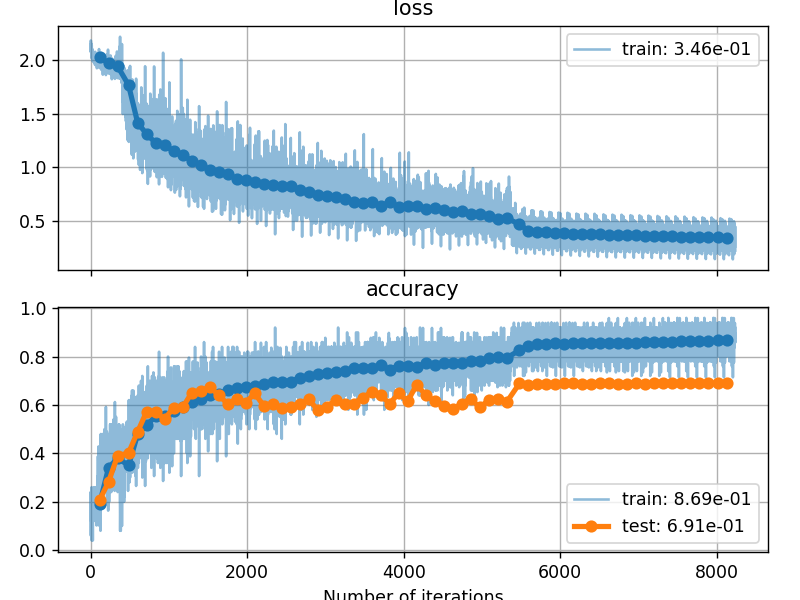

In [1179]:
import liveplot
plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=2.5)

In [1182]:
from mynn.losses.cross_entropy import softmax_cross_entropy
from math import ceil

optim.learning_rate = 1e-4
optim.weight_decay = 1e-6

batch_size = 50
epochs = 25

Ntrain = ceil(xtrain.shape[0] / batch_size)
Ntest = ceil(xtest.shape[0] / batch_size)
for epoch in range(epochs):
    # train
    for x, y in zip(np.array_split(xtrain, Ntrain), np.array_split(ytrain, Ntrain)):
        y_pred = model(x)

        loss = softmax_cross_entropy(y_pred, y)
        acc = accuracy(y_pred, y)

        loss.backward()
        optim.step()
        loss.null_gradients()

        plotter.set_train_batch({"loss":loss.item(),
                                 "accuracy":acc},
                                 batch_size=batch_size)
    # test
    for x, y in zip(np.array_split(xtest, Ntest), np.array_split(ytest, Ntest)):
        y_pred = model(x)
        
        acc = accuracy(y_pred, y)

        y_pred.null_gradients()

        plotter.set_test_batch({"accuracy":acc}, 
                                 batch_size=batch_size)
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()

---------------------------------------------
Now, try with a real picture!

<IPython.core.display.Javascript object>


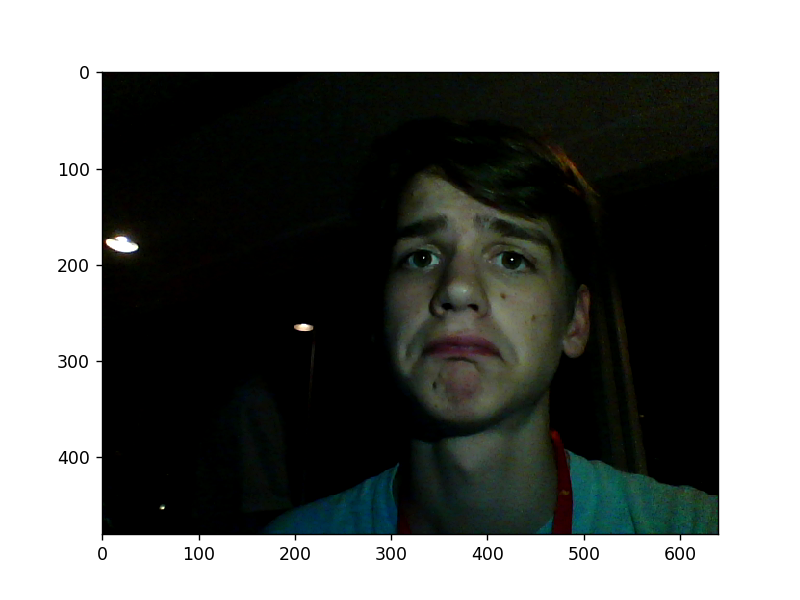

In [1331]:
# take picture!
fig,ax = plt.subplots()
pic = take_picture()
ax.imshow(pic)

In [1332]:
detections = list(face_detect(pic))
print(detections)

[rectangle(281,137,496,352)]


<IPython.core.display.Javascript object>


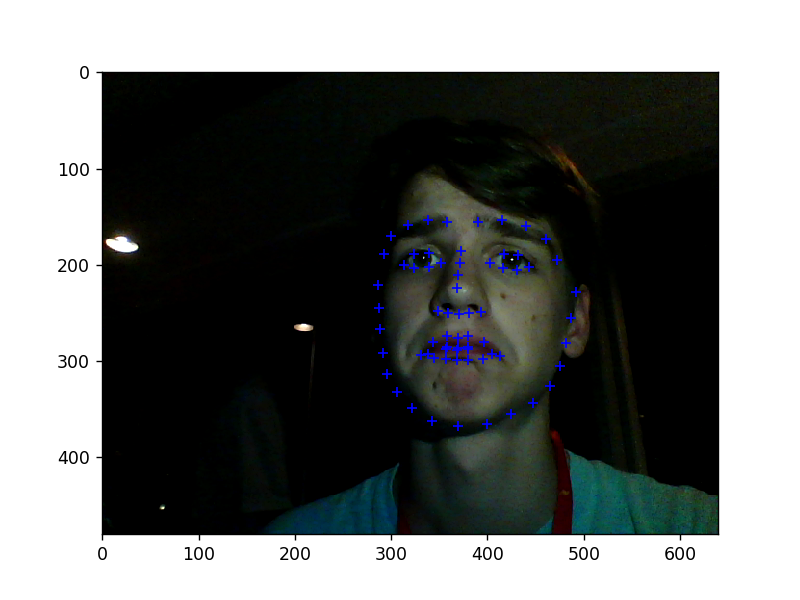

Number of faces detected: 1


In [1333]:
from matplotlib.patches import Rectangle
fig,ax = plt.subplots()
ax.imshow(pic)


print("Number of faces detected: {}".format(len(detections)))
for k, d in enumerate(detections):
    # Get the landmarks/parts for the face in box d.
    landmarks = shape_predictor(pic, d)
    # Draw the face landmarks on the screen.
    for i in range(68):
        ax.plot(landmarks.part(i).x,landmarks.part(i).y,'+',color="blue")

In [1326]:
landmarks = shape_predictor(pic, detections[0])
landmarks_arr = np.empty((68, 2))
for i in range(68):
    landmarks_arr[i, 0] = landmarks.part(i).x
    landmarks_arr[i, 1] = landmarks.part(i).y

mean = np.mean(landmarks_arr, axis=0)
std = np.std(landmarks_arr, axis=0)
landmarks_norm = (landmarks_arr - mean) / std

<IPython.core.display.Javascript object>


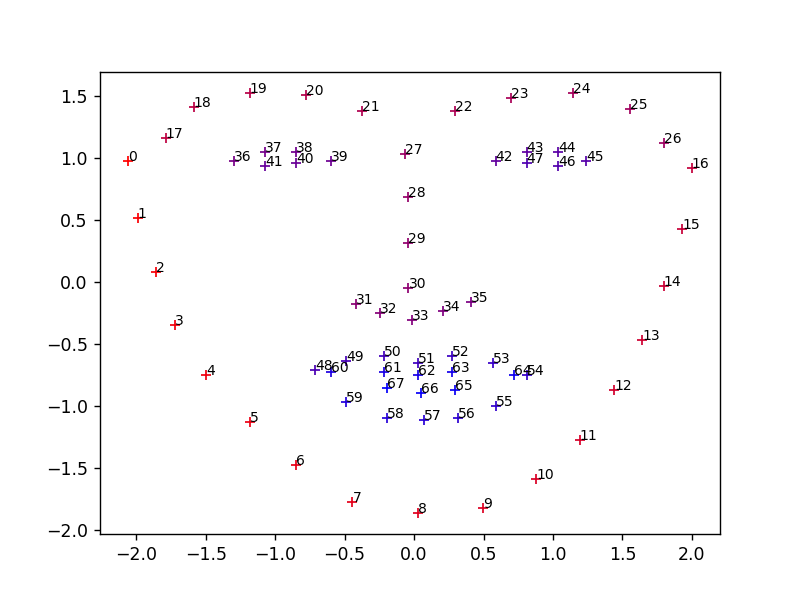

In [1327]:
fig,ax = plt.subplots()

for i in range(68):
    ax.plot(landmarks_norm[i][0],-landmarks_norm[i][1],'+',color=(1-i/68, 0, i/68))
    ax.text(landmarks_norm[i][0],-landmarks_norm[i][1],str(i),color="black",fontsize=8)

In [1328]:
from mynn.activations.softmax import softmax

# try to detect the emotion
landmarks_final = landmarks_norm.reshape(68*2)

labels = ["neutral", "angry", "contempt", "disgusted", "afraid", "happy", "sad", "surprised"]
probs = model(landmarks_final)
probs_soft = softmax(probs)
result = {emotion:probs_soft.data[0][i] for i, emotion in enumerate(labels)}

In [1329]:
top_emotion = max(result.keys(), key=(lambda k: result[k]))
print("You are " + '%.2f' % (result[top_emotion]*100) + "% " + top_emotion)

You are 63.72% neutral
